Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

# XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

# Feature importance
from sklearn.inspection import permutation_importance

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("All libraries imported successfully!")

All libraries imported successfully!


Load the Dataset

In [2]:
# Load your preprocessed data
file_path = r'C:\Users\Yasara\Downloads\ATOMIC-DementiaPredictionModel\training_dataset.csv'
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum().sum()} total missing values")

# Check data types
print(f"\nData types:\n{df.dtypes.value_counts()}")

Dataset loaded successfully!
Shape: (195195, 67)

First few rows:
   ALCOCCAS  ANXIETY  APNEA  ARTHRIT  BILLS  BIRTHMO  BIRTHYR  DEMENTED  \
0         2        2      1        1      1        5     1952         1   
1         2        1      1        1      2        5     1952         1   
2         2        1      1        1      1       12     1956         1   
3         1        1      1        1      4        1     1958         2   
4         2        1      1        1      1        2     1945         1   

   DEP2YRS  EDUC  EVENTS  GAMES  HATTMULT  HISPOR  INBIRMO  INBIRYR  INCALLS  \
0        1    16       2      1         3       8        5     1962        7   
1        1    16       2      1         3       8        5     1962        7   
2        1    16       1      1         3       8        3     1958        7   
3        1    16       4      4         3       1        9     1947        7   
4        1    12       1      1         3       1        2     1950        1   

  

Separate Features and Target

In [3]:
df.shape

(195195, 67)

Target column 'DEMENTED' found!

Features shape: (195195, 66)
Target shape: (195195,)

Class Distribution:
DEMENTED
1    137605
2     57590
Name: count, dtype: int64

Class Distribution (%):
DEMENTED
1    70.49617
2    29.50383
Name: proportion, dtype: float64


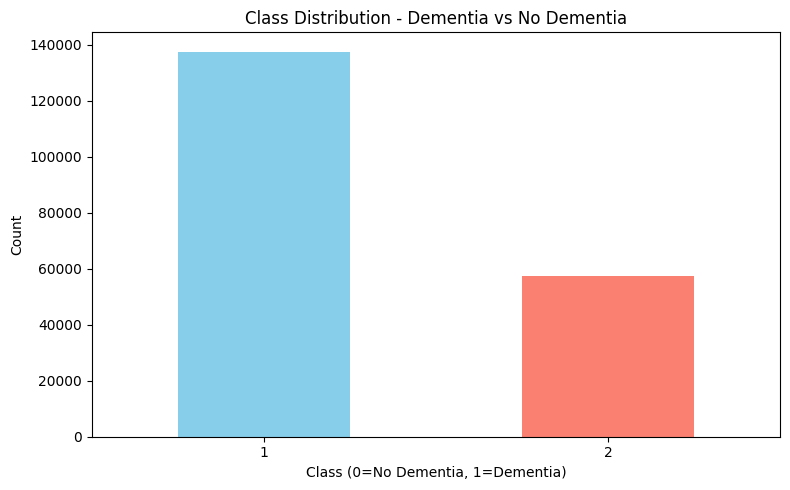

In [4]:
# Define target variable
target = 'DEMENTED'

# Check if target exists
if target not in df.columns:
    print(f"ERROR: Target column '{target}' not found!")
    print(f"Available columns: {df.columns.tolist()}")
else:
    print(f"Target column '{target}' found!")

# Separate features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check class distribution
print(f"\nClass Distribution:")
print(y.value_counts())
print(f"\nClass Distribution (%):")
print(y.value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution - Dementia vs No Dementia')
plt.xlabel('Class (0=No Dementia, 1=Dementia)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Split Data into Train and Test Sets

In [5]:
# Check current values in DEMENTED
print("Current DEMENTED values:")
print(df['DEMENTED'].value_counts().sort_index())

# Remap DEMENTED: 1 -> 0 (No Dementia), 2 -> 1 (Dementia)
# OR if 1 means Dementia and 2 means No Dementia, adjust accordingly
df['DEMENTED'] = df['DEMENTED'].map({1: 0, 2: 1})

# Verify the mapping
print("\nAfter remapping:")
print(df['DEMENTED'].value_counts().sort_index())

# Now separate features and target
X = df.drop(columns=['DEMENTED'])
y = df['DEMENTED']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Check class distribution
print(f"\nTrain set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest set class distribution:")
print(y_test.value_counts().sort_index())

# Calculate class imbalance ratio
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")

Current DEMENTED values:
DEMENTED
1    137605
2     57590
Name: count, dtype: int64

After remapping:
DEMENTED
0    137605
1     57590
Name: count, dtype: int64

Training set size: (156156, 66)
Test set size: (39039, 66)

Train set class distribution:
DEMENTED
0    110084
1     46072
Name: count, dtype: int64

Test set class distribution:
DEMENTED
0    27521
1    11518
Name: count, dtype: int64

Class imbalance ratio: 2.39


Feature Scaling

In [6]:
# Note: XGBoost doesn't strictly require scaling, but it can help
# Uncomment if you want to scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("Feature scaling completed!")

print("Skipping feature scaling (XGBoost works well without it)")

Feature scaling completed!
Skipping feature scaling (XGBoost works well without it)


Build Baseline XGBoost Model

In [7]:
print("="*60)
print("BUILDING BASELINE XGBOOST MODEL")
print("="*60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Create baseline XGBoost model
baseline_xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1
)

# Train baseline model
print("\nTraining baseline model...")
baseline_xgb.fit(X_train, y_train)
print("Training completed!")

# Make predictions
y_pred_baseline = baseline_xgb.predict(X_test)
y_pred_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]

# Evaluate baseline model
print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

BUILDING BASELINE XGBOOST MODEL

Training baseline model...
Training completed!

BASELINE MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27521
           1       0.85      0.94      0.89     11518

    accuracy                           0.93     39039
   macro avg       0.91      0.93      0.92     39039
weighted avg       0.94      0.93      0.93     39039


Accuracy: 0.9311
Precision: 0.8451
Recall: 0.9384
F1-Score: 0.8893
ROC-AUC: 0.9833


Confusion Matrix Visualization

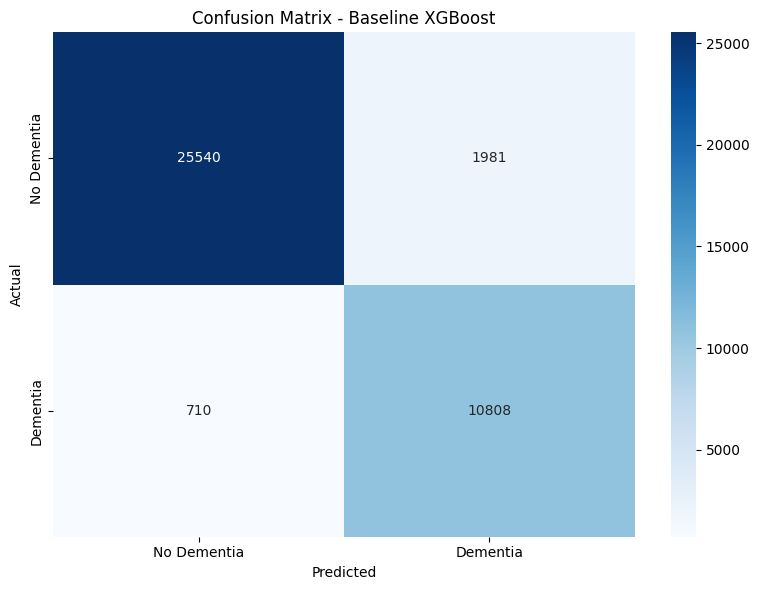


True Negatives: 25540
False Positives: 1981
False Negatives: 710
True Positives: 10808

Specificity: 0.9280
Sensitivity (Recall): 0.9384


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.title('Confusion Matrix - Baseline XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Specificity and Sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print(f"\nSpecificity: {specificity:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")

ROC Curve

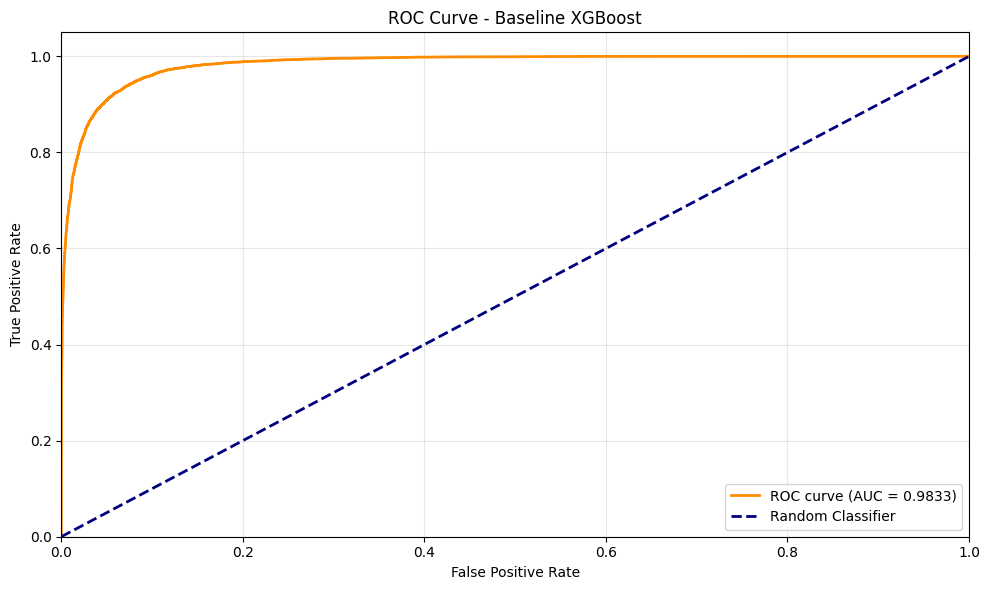

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_baseline)
roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline XGBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Precision-Recall Curve

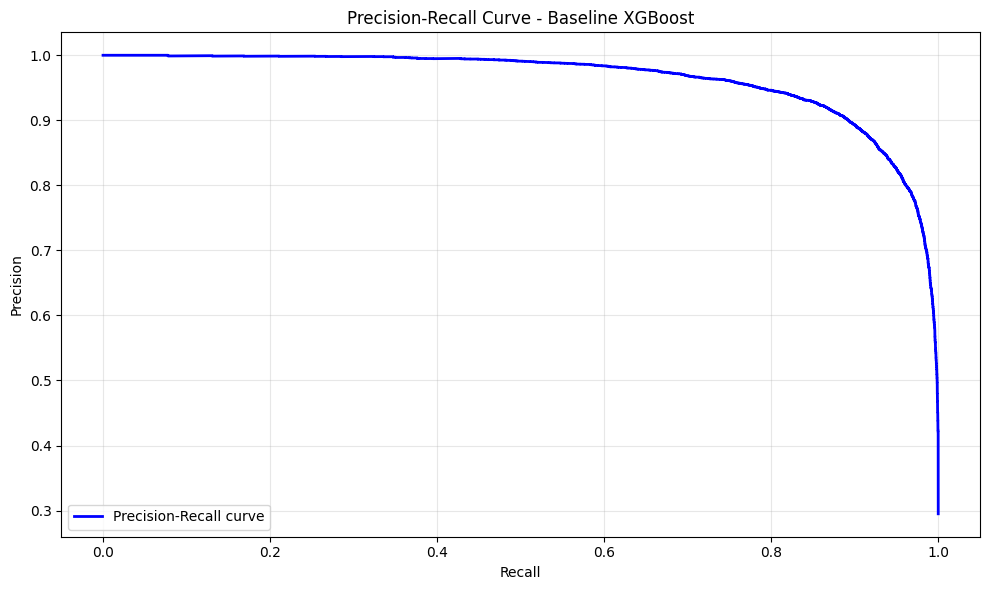

In [11]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_baseline)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline XGBoost')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Hyperparameter Tuning with GridSearchCV

In [ ]:
print("="*60)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

# For faster execution, use a smaller grid first
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0, 0.1]
}

# Choose which grid to use
# param_grid_to_use = param_grid_small  # Use this for faster tuning
param_grid_to_use = param_grid  # Use this for comprehensive tuning

# Create base model
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist'
)

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
print("\nStarting GridSearchCV...")
print(f"Total combinations to test: {np.prod([len(v) for v in param_grid_to_use.values()])}")
print("This may take several minutes...\n")

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_to_use,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=2,
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

print("\nGridSearchCV completed!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search.best_score_:.4f}")

Evaluate Tuned Model

In [ ]:
print("="*60)
print("TUNED MODEL PERFORMANCE")
print("="*60)

# Get best model
best_xgb = grid_search.best_estimator_

# Make predictions with tuned model
y_pred_tuned = best_xgb.predict(X_test)
y_pred_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate tuned model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

# Compare with baseline
print("\n" + "="*60)
print("BASELINE vs TUNED MODEL COMPARISON")
print("="*60)
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        accuracy_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_baseline),
        roc_auc_score(y_test, y_pred_proba_baseline)
    ],
    'Tuned': [
        accuracy_score(y_test, y_pred_tuned),
        precision_score(y_test, y_pred_tuned),
        recall_score(y_test, y_pred_tuned),
        f1_score(y_test, y_pred_tuned),
        roc_auc_score(y_test, y_pred_proba_tuned)
    ]
})
comparison['Improvement'] = comparison['Tuned'] - comparison['Baseline']
print(comparison.to_string(index=False))

Feature Importance Analysis

In [ ]:
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from the model
feature_importance = best_xgb.feature_importances_

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save feature importance to CSV
feature_importance_df.to_csv('feature_importance_xgboost.csv', index=False)
print("\nFeature importance saved to 'feature_importance_xgboost.csv'")

Cross-Validation Score

In [ ]:
print("="*60)
print("CROSS-VALIDATION PERFORMANCE")
print("="*60)

# Perform cross-validation on the best model
cv_scores = cross_val_score(
    best_xgb, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"\nCross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f}")
print(f"Std CV ROC-AUC: {cv_scores.std():.4f}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title('Cross-Validation ROC-AUC Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Save the Trained Model

In [ ]:
import pickle

print("="*60)
print("SAVING THE MODEL")
print("="*60)

# Save the best model
model_filename = 'xgboost_dementia_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_xgb, file)

print(f"\nModel saved as '{model_filename}'")

# Save model parameters
params_filename = 'xgboost_best_params.txt'
with open(params_filename, 'w') as f:
    f.write("Best XGBoost Parameters:\n")
    f.write("="*50 + "\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")
    f.write("\n" + "="*50 + "\n")
    f.write(f"Best CV ROC-AUC Score: {grid_search.best_score_:.4f}\n")

print(f"Best parameters saved to '{params_filename}'")

# Test loading the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Verify loaded model works
test_prediction = loaded_model.predict(X_test[:5])
print(f"\nModel loaded successfully! Test prediction: {test_prediction}")

Generate Final Report Summary

In [ ]:
print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)

final_report = f"""
XGBoost Dementia Prediction Model - Final Report
{'='*60}

Dataset Information:
- Total samples: {df.shape[0]}
- Total features: {X.shape[1]}
- Training samples: {X_train.shape[0]}
- Test samples: {X_test.shape[0]}
- Class imbalance ratio: {imbalance_ratio:.2f}

Best Hyperparameters:
{grid_search.best_params_}

Model Performance on Test Set:
- Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}
- Precision: {precision_score(y_test, y_pred_tuned):.4f}
- Recall: {recall_score(y_test, y_pred_tuned):.4f}
- F1-Score: {f1_score(y_test, y_pred_tuned):.4f}
- ROC-AUC: {roc_auc_score(y_test, y_pred_proba_tuned):.4f}

Cross-Validation Performance:
- Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})

Top 5 Most Important Features:
{feature_importance_df.head(5).to_string(index=False)}

Model saved as: {model_filename}
"""

print(final_report)

# Save report to file
with open('xgboost_model_report.txt', 'w') as f:
    f.write(final_report)

print("\nReport saved to 'xgboost_model_report.txt'")
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)